# Behavior Analysis: LUPE-AMPS 

Press SHIFT + ENTER to run code

### USER INPUT!

In [1]:
## Define project
project_name = 'project_Sandra_Form1perc_Proglumide_CohortCombined'

# Select group and condition, see meta.py to see how you previously defined it for your project
selected_groups = ['Combined']
selected_conditions = ['Saline','Proglumide']

## Main Code: Analyze Novel Data on LUPE-AMPS 

### Section 1: Preprocessing and File Analysis

In [2]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.stats import mode
from scipy.ndimage import label

# Define base directory for CSV files.
novel_data_base_dir = f'../processed_dataset/{project_name}/figures/behaviors_csv_raw-classification/frames'

# Preprocessing parameters (as in the LUPE‑AMPS model)
dtB = 60                      # original sampling rate (fps)
dt = 20                       # desired sampling rate (fps)
recLength = 30                # recording length (minutes)
original_length = 60 * dtB * recLength  # e.g., 108000 frames
n_downsampled = int(original_length * (dt / dtB))  # e.g., 36000 frames

# Initialize lists for metrics.
novel_occ = []      # Fraction occupancy vector (6 states) per time window.
novel_nBouts = []   # Number of bouts per state (6 values per time window).
novel_boutDur = []  # Mean bout duration (seconds, 6 values per time window).
anOrder_novel = []  # CSV file names (animal IDs), per time window.
group_labels = []   # Group for each time window.
condition_labels = []  # Condition for each time window.
time_group_labels = []  # one entry per occupancy vector/time window
total_files = 0

for group in selected_groups:
    group_dir = os.path.join(novel_data_base_dir, group)
    print(f"Processing group directory: {group_dir}")
    for condition in selected_conditions:
        condition_dir = os.path.join(group_dir, condition)
        print(f"  Processing condition directory: {condition_dir}")
        csv_files = glob.glob(os.path.join(condition_dir, "*.csv"))
        csv_files.sort()
        print(f"    Found {len(csv_files)} CSV files.")
        for file in csv_files:
            baseFileName = os.path.basename(file)
            try:
                data = pd.read_csv(file)
            except Exception as e:
                print(f"      Skipping {baseFileName} due to error: {e}")
                continue
            data_array = data.to_numpy()
            if data_array.shape[0] < original_length:
                behav = np.concatenate([data_array[:data_array.shape[0], 1],
                                        np.zeros(original_length - data_array.shape[0])])
            else:
                behav = data_array[:original_length, 1]
            # Downsample (group every 3 frames: 60 -> 20 fps)
            downsampled = []
            window_size = int(1 / (dt / dtB))  # equals 3
            for i in range(0, len(behav), window_size):
                window = behav[i:i+window_size]
                if len(window) == 0:
                    break
                m = mode(window)
                value = m.mode[0] if hasattr(m.mode, '__iter__') else m.mode
                downsampled.append(value)
            downsampled = np.array(downsampled)
            # Assign time in minutes for each downsampled sample (20 fps → dt samples per second)
            time_seconds = np.arange(len(downsampled)) / dt
            time_minutes = time_seconds / 60
            bins = [0, 10, 60]
            labels = ['0-10 min', '11-60 min']
            # Create a time_group array of length len(downsampled)
            time_group = pd.cut(time_minutes, bins=bins, labels=labels, right=False)
            if len(downsampled) < n_downsampled:
                downsampled = np.pad(downsampled, (0, n_downsampled - len(downsampled)), mode='constant')
            elif len(downsampled) > n_downsampled:
                downsampled = downsampled[:n_downsampled]
            # Compute metrics for each time window separately
            for tg_label in labels:
                mask = (time_group == tg_label)
                seg = downsampled[mask]
                # occupancy
                occ_vec = [np.sum(seg == state) / len(seg) if len(seg)>0 else 0 for state in range(6)]
                # bouts and durations
                nB_vec = []
                dur_vec = []
                for state in range(6):
                    state_bin = (seg == state).astype(int)
                    lab, num = label(state_bin)
                    nB_vec.append(num)
                    durations = [np.sum(lab == i) / dt for i in range(1, num+1)]
                    dur_vec.append(np.mean(durations) if durations else 0)
                # append to lists
                novel_occ.append(occ_vec)
                novel_nBouts.append(nB_vec)
                novel_boutDur.append(dur_vec)
                time_group_labels.append(tg_label)
                anOrder_novel.append(baseFileName)
                group_labels.append(group)
                condition_labels.append(condition)
                total_files += 1

print("Total files processed:", total_files)
novel_occ = np.array(novel_occ)   # Shape: (num_files, 6)
novel_nBouts = np.array(novel_nBouts)
novel_boutDur = np.array(novel_boutDur)
print("novel_occ shape:", novel_occ.shape)
if novel_occ.size == 0 or novel_occ.ndim != 2:
    raise ValueError("novel_occ is empty or not 2D. Check your input data and file paths.")

Processing group directory: ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behaviors_csv_raw-classification/frames/Combined
  Processing condition directory: ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behaviors_csv_raw-classification/frames/Combined/Saline
    Found 18 CSV files.
  Processing condition directory: ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behaviors_csv_raw-classification/frames/Combined/Proglumide
    Found 19 CSV files.
Total files processed: 74
novel_occ shape: (74, 6)


 ### Section 2: PCA Projection and Scatter Plot

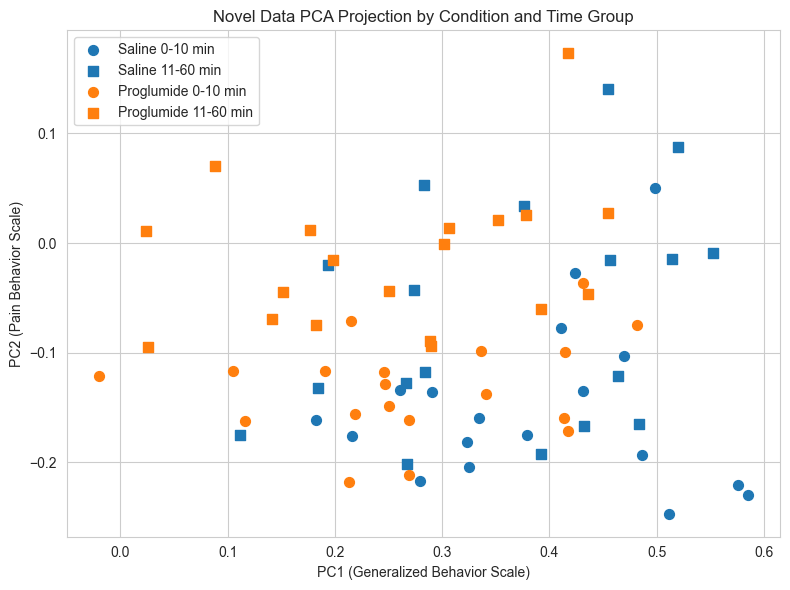

In [3]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.stats import mode
from scipy.ndimage import label
import matplotlib.pyplot as plt
import pickle
from scipy.spatial.distance import cdist
import seaborn as sns

# ------------------------------
# Load pre-fitted PCA model.
# ------------------------------
pca_model_path = '../model/model_LUPE-AMPS.pkl'
with open(pca_model_path, 'rb') as f:
    pca = pickle.load(f)

# (Make sure you’ve already defined `novel_occ`, `condition_labels`, and `anOrder_novel` above this point.)

# ------------------------------
# Project occupancy data into PCA space.
# ------------------------------
novel_projection = pca.transform(novel_occ)
novel_projection_2 = novel_projection[:, :2]
pc1_novel = novel_projection_2[:, 0]
pc2_novel = novel_projection_2[:, 1]

# ------------------------------
# Define output directory.
# ------------------------------
output_dir_novel = os.path.join(
    '..', 'processed_dataset', project_name, 'figures', 'behaviors_LUPE-AMPS', 'Section2'
)
os.makedirs(output_dir_novel, exist_ok=True)

# ------------------------------
# Dynamically assign one color per condition
# ------------------------------
# 1. Grab a seaborn/matplotlib palette of length = number of conditions.
palette = sns.color_palette('tab10', n_colors=len(selected_conditions))

# 2. Zip condition names to palette entries.
condition_colors = dict(zip(selected_conditions, palette))

# Example result if selected_conditions = ['Male','Female','Combined']:
# condition_colors might be {'Male': (0.121, 0.466, 0.705), 
#                            'Female': (1.000, 0.498, 0.054), 
#                            'Combined': (0.172, 0.627, 0.172)}


# ------------------------------
# NOTE: Ensure you have executed Section 1 so that time_group_labels is populated.

# ------------------------------
# Export the PCA projection data to a CSV file, and add TimeGroup to DataFrame.
# ------------------------------
df_novel_projection = pd.DataFrame(novel_projection_2, columns=["PC1", "PC2"])
df_novel_projection["Animal"] = anOrder_novel
df_novel_projection["Condition"] = condition_labels
df_novel_projection["TimeGroup"] = time_group_labels
csv_proj_path = os.path.join(
    output_dir_novel,
    f"{project_name}_novel_data_projection.csv"
)
df_novel_projection.to_csv(csv_proj_path, index=False)

# ------------------------------
# Scatter plot of PCA projection by condition and time group.
# ------------------------------
plt.figure(figsize=(8, 6))
unique_tgs = df_novel_projection["TimeGroup"].unique()
markers = ['o', 's']
for ic, condition in enumerate(selected_conditions):
    for it, tg in enumerate(unique_tgs):
        subset = df_novel_projection[
            (df_novel_projection["Condition"] == condition) &
            (df_novel_projection["TimeGroup"] == tg)
        ]
        plt.scatter(
            subset["PC1"],
            subset["PC2"],
            color=condition_colors[condition],
            marker=markers[it % len(markers)],
            label=f"{condition} {tg}",
            s=50
        )

plt.xlabel("PC1 (Generalized Behavior Scale)")
plt.ylabel("PC2 (Pain Behavior Scale)")
plt.title("Novel Data PCA Projection by Condition and Time Group")
plt.legend(loc='best')
plt.tight_layout()

# Save the figure as PNG.
novel_fig_png = os.path.join(
    output_dir_novel,
    f"{project_name}_novel_data_projection.png"
)
plt.savefig(novel_fig_png, dpi=300)

# Save the figure as SVG.
novel_fig_svg = os.path.join(
    output_dir_novel,
    f"{project_name}_novel_data_projection.svg"
)
plt.savefig(novel_fig_svg, format="svg")
plt.show()

### Section 3: Multi-graph Line Plots for Metrics

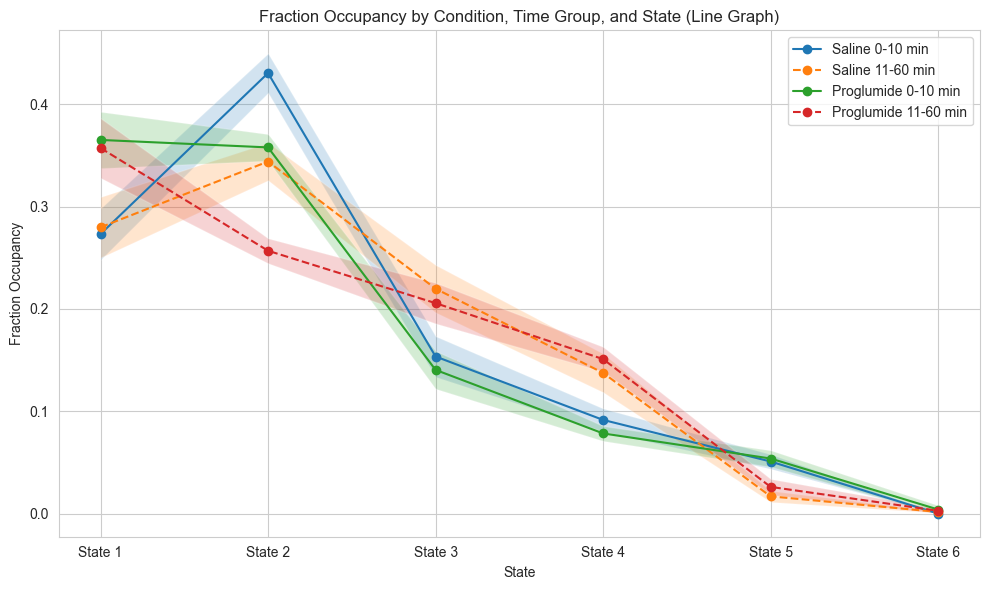

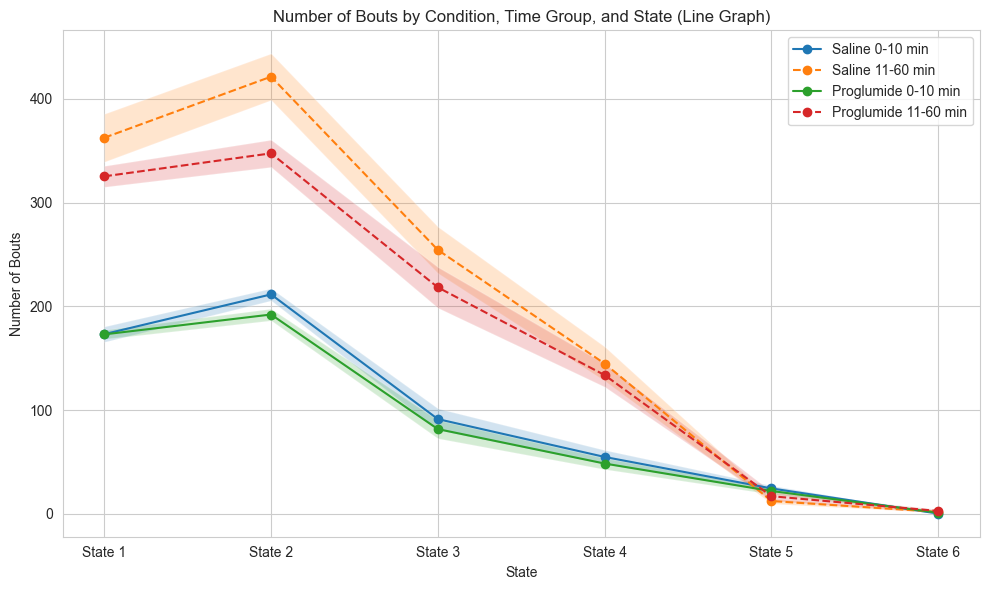

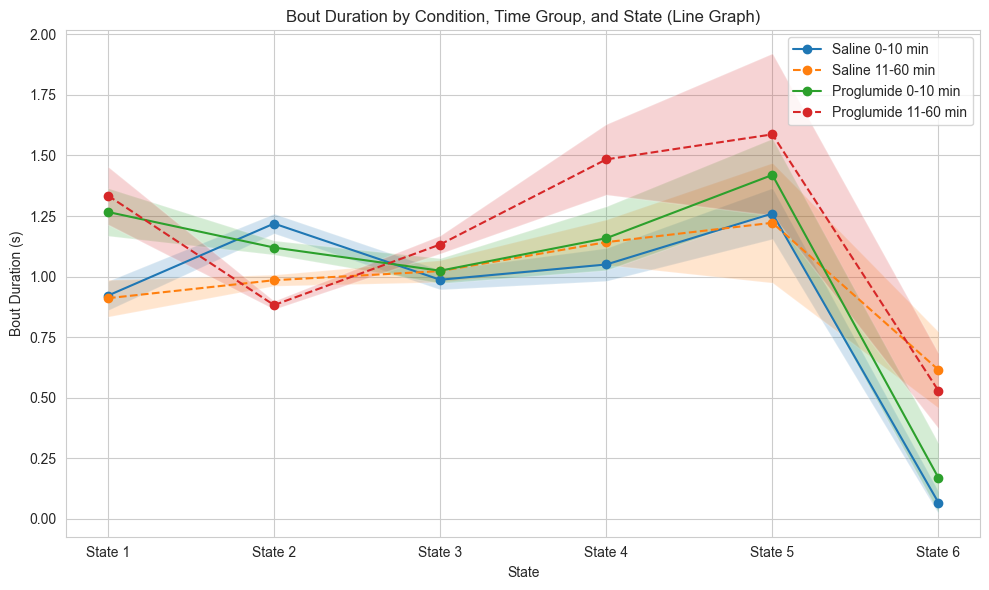

In [4]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.stats import mode
from scipy.ndimage import label
import matplotlib.pyplot as plt
import seaborn as sns

# Define output directory for Section 3.
output_dir_novel = f'../processed_dataset/{project_name}/figures/behaviors_LUPE-AMPS/Section3'
os.makedirs(output_dir_novel, exist_ok=True)

# Define the list of states.
states = [f"State {i+1}" for i in range(6)]

# ----- Fraction Occupancy Line Graph -----
df_occ_animals = pd.DataFrame(novel_occ, columns=states)
df_occ_animals["Condition"] = condition_labels
df_occ_animals["Animal"] = anOrder_novel  # include file names for traceability
df_occ_animals["TimeGroup"] = time_group_labels

fig, ax = plt.subplots(figsize=(10, 6))
xvals = np.arange(len(states))
unique_tgs = df_occ_animals["TimeGroup"].unique()
linestyles = ['-', '--']
for condition in selected_conditions:
    for it, tg in enumerate(unique_tgs):
        subset = df_occ_animals[
            (df_occ_animals["Condition"] == condition) &
            (df_occ_animals["TimeGroup"] == tg)
        ]
        means = subset[states].mean()
        sem = subset[states].std(ddof=1) / np.sqrt(len(subset))
        ax.plot(xvals, means, marker='o', linestyle=linestyles[it % len(linestyles)], label=f"{condition} {tg}")
        ax.fill_between(xvals, means - sem, means + sem, alpha=0.2)
ax.set_xticks(xvals)
ax.set_xticklabels(states)
ax.set_xlabel("State")
ax.set_ylabel("Fraction Occupancy")
ax.set_title("Fraction Occupancy by Condition, Time Group, and State (Line Graph)")
ax.legend()
plt.tight_layout()

# Save as PNG and SVG.
occ_fig_png = os.path.join(output_dir_novel, f"{project_name}_novel_fraction_occupancy_by_condition_line.png")
occ_fig_svg = os.path.join(output_dir_novel, f"{project_name}_novel_fraction_occupancy_by_condition_line.svg")
plt.savefig(occ_fig_png)
plt.savefig(occ_fig_svg, format="svg")
plt.show()


# ----- Number of Bouts Line Graph -----
df_bouts_animals = pd.DataFrame(novel_nBouts, columns=states)
df_bouts_animals["Condition"] = condition_labels
df_bouts_animals["Animal"] = anOrder_novel
df_bouts_animals["TimeGroup"] = time_group_labels

fig, ax = plt.subplots(figsize=(10, 6))
xvals = np.arange(len(states))
unique_tgs = df_bouts_animals["TimeGroup"].unique()
linestyles = ['-', '--']
for condition in selected_conditions:
    for it, tg in enumerate(unique_tgs):
        subset = df_bouts_animals[
            (df_bouts_animals["Condition"] == condition) &
            (df_bouts_animals["TimeGroup"] == tg)
        ]
        means = subset[states].mean()
        sem = subset[states].std(ddof=1) / np.sqrt(len(subset))
        ax.plot(xvals, means, marker='o', linestyle=linestyles[it % len(linestyles)], label=f"{condition} {tg}")
        ax.fill_between(xvals, means - sem, means + sem, alpha=0.2)
ax.set_xticks(xvals)
ax.set_xticklabels(states)
ax.set_xlabel("State")
ax.set_ylabel("Number of Bouts")
ax.set_title("Number of Bouts by Condition, Time Group, and State (Line Graph)")
ax.legend()
plt.tight_layout()

bouts_fig_png = os.path.join(output_dir_novel, f"{project_name}_novel_number_of_bouts_by_condition_line.png")
bouts_fig_svg = os.path.join(output_dir_novel, f"{project_name}_novel_number_of_bouts_by_condition_line.svg")
plt.savefig(bouts_fig_png)
plt.savefig(bouts_fig_svg, format="svg")
plt.show()


# ----- Bout Duration Line Graph -----
df_boutdur_animals = pd.DataFrame(novel_boutDur, columns=states)
df_boutdur_animals["Condition"] = condition_labels
df_boutdur_animals["Animal"] = anOrder_novel
df_boutdur_animals["TimeGroup"] = time_group_labels

fig, ax = plt.subplots(figsize=(10, 6))
xvals = np.arange(len(states))
unique_tgs = df_boutdur_animals["TimeGroup"].unique()
linestyles = ['-', '--']
for condition in selected_conditions:
    for it, tg in enumerate(unique_tgs):
        subset = df_boutdur_animals[
            (df_boutdur_animals["Condition"] == condition) &
            (df_boutdur_animals["TimeGroup"] == tg)
        ]
        means = subset[states].mean()
        sem = subset[states].std(ddof=1) / np.sqrt(len(subset))
        ax.plot(xvals, means, marker='o', linestyle=linestyles[it % len(linestyles)], label=f"{condition} {tg}")
        ax.fill_between(xvals, means - sem, means + sem, alpha=0.2)
ax.set_xticks(xvals)
ax.set_xticklabels(states)
ax.set_xlabel("State")
ax.set_ylabel("Bout Duration (s)")
ax.set_title("Bout Duration by Condition, Time Group, and State (Line Graph)")
ax.legend()
plt.tight_layout()

boutdur_fig_png = os.path.join(output_dir_novel, f"{project_name}_novel_bout_duration_by_condition_line.png")
boutdur_fig_svg = os.path.join(output_dir_novel, f"{project_name}_novel_bout_duration_by_condition_line.svg")
plt.savefig(boutdur_fig_png)
plt.savefig(boutdur_fig_svg, format="svg")
plt.show()

# ----- Export CSV files with project name in the filename.
csv_occ_path = os.path.join(output_dir_novel, f"{project_name}_novel_fraction_occupancy_by_condition.csv")
csv_bouts_path = os.path.join(output_dir_novel, f"{project_name}_novel_number_of_bouts_by_condition.csv")
csv_boutdur_path = os.path.join(output_dir_novel, f"{project_name}_novel_bout_duration_by_condition.csv")
df_occ_animals.to_csv(csv_occ_path, index=False)
df_bouts_animals.to_csv(csv_bouts_path, index=False)
df_boutdur_animals.to_csv(csv_boutdur_path, index=False)

### Section 4: Model Fit Analysis

ditMeans shape: (2, 9, 100)
match shape: (2, 9, 100)
Aggregated summary CSV saved at: ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behaviors_LUPE-AMPS/Section4/ditMeans_Summary_allConditions.csv


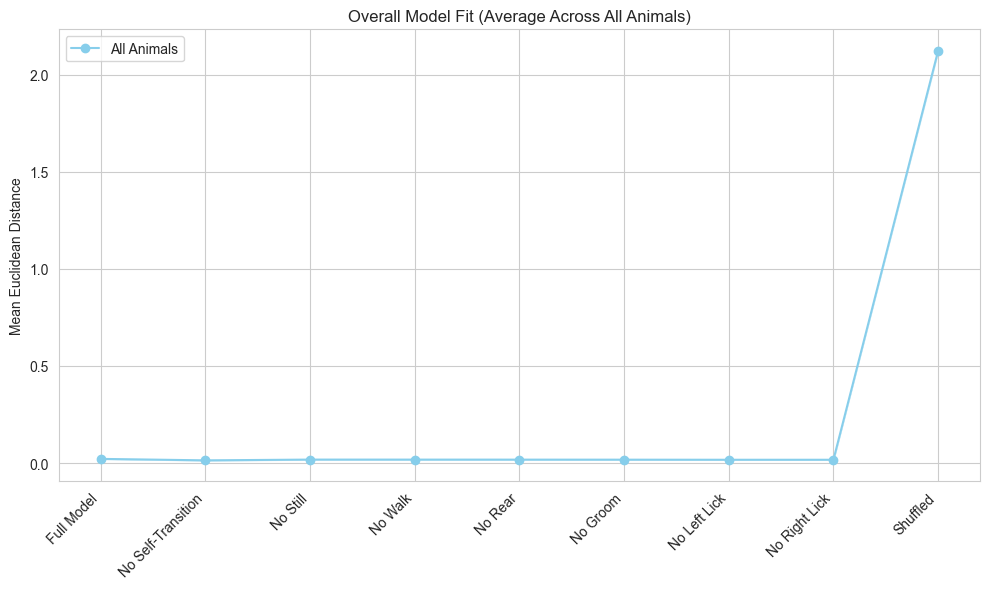

Overall Model Fit line graph saved as PNG at: ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behaviors_LUPE-AMPS/Section4/model_Section4_fit_line_overall.png
Overall Model Fit line graph saved as SVG at: ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behaviors_LUPE-AMPS/Section4/model_Section4_fit_line_overall.svg


/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


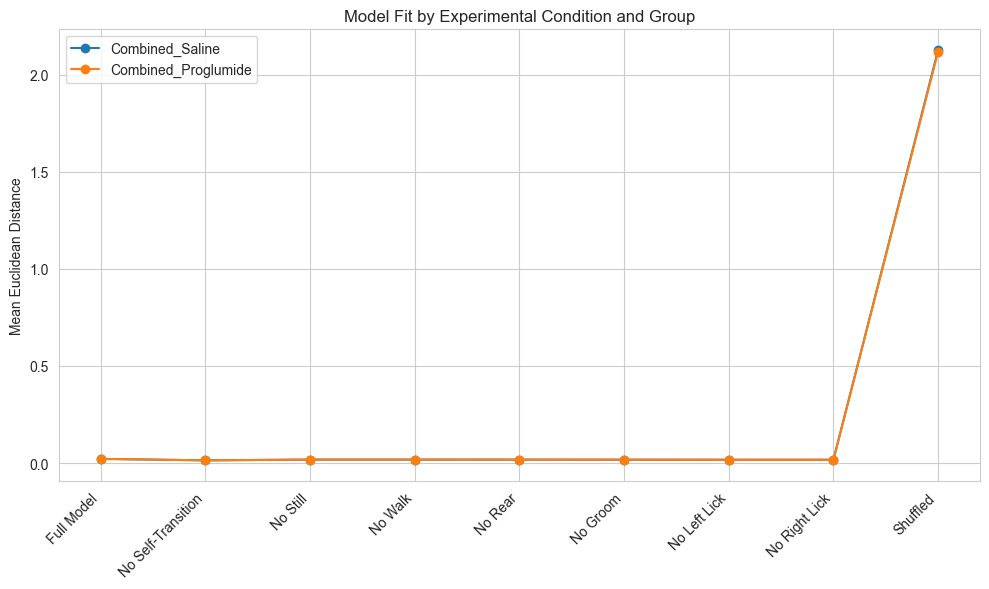

Group comparison line graph saved as PNG at: ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behaviors_LUPE-AMPS/Section4/model_Section4_fit_line_by_experimental_condition.png
Group comparison line graph saved as SVG at: ../processed_dataset/project_Sandra_Form1perc_Proglumide_CohortCombined/figures/behaviors_LUPE-AMPS/Section4/model_Section4_fit_line_by_experimental_condition.svg


In [5]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pandas as pd
import os

# Create animal information as the Cartesian product of selected_groups and selected_conditions.
# (Each combination yields one animal; modify if you have multiple animals per combination.)
animal_list = []
for group in selected_groups:
    for cond in selected_conditions:
        animal_list.append({"animal_id": f"{group}_{cond}", "group": group, "condition": cond})
animal_info = pd.DataFrame(animal_list)
num_animals = animal_info.shape[0]  # Total number of animals

# ====================================================
# SECTION 4: PARAMETERS AND WINDOWING SETUP
# ====================================================
nSecs = 30       # window length (sec)
toSlide = 10     # sliding step (sec)
nBeh = 6         # number of behaviors
dt = 20          # frames per sec
recLength = 30   # recording length in minutes

winSize = dt * nSecs             # e.g., 600 frames
winSlide = dt * toSlide          # e.g., 200 frames
total_frames = dt * recLength * 60  # e.g., 108000 frames

# Create window boundaries (MATLAB-style 1-indexed)
wins = np.arange(1, total_frames + 1, winSlide)
wins = wins[wins + winSize + 1 <= total_frames]  # exclude windows that extend beyond total_frames
nWins = len(wins)

# ------------------------------
# Phase Handling (e.g., first 10 minutes)
# ------------------------------
phase = 0  # 0 = whole session; set 1 or 2 if needed.
winsP1 = np.arange(1, dt*10*60 + 1, winSlide)
winsP1 = winsP1[winsP1 + winSize + 1 <= dt*10*60]
nWinsP1 = len(winsP1)
if phase == 1:
    times = np.arange(0, nWinsP1)
elif phase == 2:
    times = np.arange(nWinsP1, nWins)
else:
    times = np.arange(0, nWins)

# Global iteration count for permutation (Condition 9)
nVals_global = 100

# ====================================================
# RESAMPLE STATE SERIES ALLOCATION
# ====================================================
resampled_length = toSlide * dt * (nWins + 1)
behState = np.zeros((resampled_length, num_animals, 9), dtype=int)

# ====================================================
# DEFINE INDEX SUBSETS (converted from MATLAB)
# ====================================================
subsetStill = np.array([0, 1, 2, 3, 4, 5, 6, 12, 18, 24, 30])
subsetWalk  = np.array([1, 6, 7, 8, 9, 10, 11, 13, 19, 25, 31])
subsetRear  = np.array([2, 8, 12, 13, 14, 15, 16, 17, 20, 26, 32])
subsetGroom = np.array([3, 9, 15, 18, 19, 20, 21, 22, 23, 27, 33])
subsetLick  = np.array([4, 10, 16, 22, 24, 25, 26, 27, 28, 29, 34])
subsetRight = np.array([5, 11, 17, 23, 29, 30, 31, 32, 33, 34, 35])
subsets = [subsetStill, subsetWalk, subsetRear, subsetGroom, subsetLick, subsetRight]

# For condition 2: use only self→other transitions.
group1 = np.arange(2, 7) - 1
group2 = np.concatenate(([1], np.arange(3, 7))) - 1
group3 = np.concatenate((np.arange(1, 3), np.arange(4, 7))) - 1
group4 = np.concatenate((np.arange(1, 4), np.array([5,6]))) - 1
group5 = np.concatenate((np.arange(1, 5), [6])) - 1
group6 = np.arange(1, 6) - 1
subset2 = np.concatenate((group1, group2, group3, group4, group5, group6))

# ====================================================
# PREALLOCATE OUTCOME VARIABLES
# ====================================================
# ditMeans: model-fit (mean Euclidean distance) per animal, per model condition, per iteration.
# match: state assignment similarity compared to the full model.
ditMeans = np.zeros((num_animals, 9, nVals_global))
match = np.zeros((num_animals, 9, nVals_global))

# ====================================================
# SIMULATED DATA FOR TRANSITION MATRICES & CENTROIDS
# ====================================================
nFeatures_full = nBeh ** 2
# transUnfolded: shape (nWins, nFeatures_full, num_animals)
transUnfolded = np.random.rand(nWins, nFeatures_full, num_animals)
# c: simulated state centroids; assume number of centroids = nBeh
k = nBeh
c = np.random.rand(k, nFeatures_full)

# ====================================================
# MAIN LOOP: COMPUTE MODEL-FIT METRICS
# ====================================================
# Model conditions:
#   l == 1: Full model (all features).
#   l == 2: Self→other transitions only.
#   l == 3 to 8: Removal of one behavior’s information (using subsets[l-3]).
#   l == 9: Shuffled centroids (permutation test).
for l in range(1, 10):   # l = 1,...,9
    if l < 9:
        nVals = 1
    else:
        nVals = nVals_global
    for v in range(nVals):
        for a in range(num_animals):
            # Extract animal a's transition data from the selected windows.
            data_animal = transUnfolded[times, :, a].copy()  # shape: (len(times), nFeatures_full)
            centroids = c.copy()  # copy centroids
            
            if l == 1:
                # Full model: no modifications.
                pass
            elif l == 2:
                # Use only self→other transitions.
                data_animal = data_animal[:, subset2]
                centroids = centroids[:, subset2]
            elif l == 9:
                # Shuffle the centroid columns.
                perm = np.random.permutation(nFeatures_full)
                centroids = centroids[:, perm]
            else:
                # Conditions 3 to 8: remove one behavior's information.
                data_animal = np.delete(data_animal, subsets[l-3], axis=1)
                centroids = np.delete(centroids, subsets[l-3], axis=1)
            
            # Compute Euclidean distances for each window.
            distances = cdist(data_animal, centroids, metric='euclidean')
            d = np.min(distances, axis=1)
            idx_min = np.argmin(distances, axis=1)
            
            # --- Resample state classifications to 20 Hz ---
            n_idx = len(idx_min)
            scaled_length = toSlide * dt * n_idx
            scaledIdx = np.zeros(scaled_length, dtype=int)
            for t in range(n_idx):
                start_idx = toSlide * dt * t
                end_idx = toSlide * dt * (t + 2)
                end_idx = min(end_idx, scaled_length)
                # Add 1 to mimic MATLAB 1-indexing
                scaledIdx[start_idx:end_idx] = idx_min[t] + 1
            
            # Store the resampled state series.
            behState[:len(scaledIdx), a, l-1] = scaledIdx
            # Store the model-fit metric.
            ditMeans[a, l-1, v] = np.mean(d)
            # For the match metric, compare with the full model (condition 1).
            if l == 1:
                full_state = scaledIdx.copy()
            else:
                full_state = behState[:len(scaledIdx), a, 0]
            match[a, l-1, v] = np.mean(full_state == scaledIdx)

print("ditMeans shape:", ditMeans.shape)   # Expected: (num_animals, 9, nVals_global)
print("match shape:", match.shape)

# ====================================================
# AGGREGATE CALCULATED ditMeans: ONE ROW PER ANIMAL
# ====================================================
# Average over permutation iterations:
avg_dit = np.mean(ditMeans, axis=2)  # shape: (num_animals, 9)
# Create an aggregated DataFrame with one row per animal.
df_all = animal_info.copy()
model_condition_names = ["Full Model", "No Self-Transition", "No Still", "No Walk", 
                         "No Rear", "No Groom", "No Left Lick", "No Right Lick", "Shuffled"]
for i, cond_name in enumerate(model_condition_names):
    df_all[cond_name] = avg_dit[:, i]

# Define a CSV output directory (for summary results).
output_dir_csv = os.path.join("..", "processed_dataset", project_name, "figures", "behaviors_LUPE-AMPS", "Section4")
os.makedirs(output_dir_csv, exist_ok=True)
csv_summary = os.path.join(output_dir_csv, "ditMeans_Summary_allConditions.csv")
df_all.to_csv(csv_summary, index=False)
print("Aggregated summary CSV saved at:", csv_summary)

# ====================================================
# FIGURE OUTPUT DIRECTORY (for plots)
# ====================================================
output_dir_novel = os.path.join("..", "processed_dataset", project_name, "figures", "behaviors_LUPE-AMPS", "Section4")
os.makedirs(output_dir_novel, exist_ok=True)

# ====================================================
# Plot 1: Overall Average Model Fit (All Animals)
# ====================================================
overall_mean = np.mean(avg_dit, axis=0)     # shape: (9,)
overall_sem = np.std(avg_dit, axis=0, ddof=1) / np.sqrt(avg_dit.shape[0])

fig1, ax1 = plt.subplots(figsize=(10, 6))
x = np.arange(len(model_condition_names))
ax1.plot(x, overall_mean, marker='o', linestyle='-', color='skyblue', label='All Animals')
ax1.fill_between(x, overall_mean - overall_sem, overall_mean + overall_sem, color='skyblue', alpha=0.3)
ax1.set_xticks(x)
ax1.set_xticklabels(model_condition_names, rotation=45, ha='right')
ax1.set_ylabel("Mean Euclidean Distance")
ax1.set_title("Overall Model Fit (Average Across All Animals)")
ax1.legend()
plt.tight_layout()

fig1_png = os.path.join(output_dir_novel, "model_Section4_fit_line_overall.png")
fig1_svg = os.path.join(output_dir_novel, "model_Section4_fit_line_overall.svg")
plt.savefig(fig1_png)
plt.savefig(fig1_svg)
plt.show()
print("Overall Model Fit line graph saved as PNG at:", fig1_png)
print("Overall Model Fit line graph saved as SVG at:", fig1_svg)

# ====================================================
# Plot 2: Group Comparison by Experimental Condition
# ====================================================
fig2, ax2 = plt.subplots(figsize=(10, 6))
x = np.arange(len(model_condition_names))
# Create a separate line for each (group, condition) combination.
for group in selected_groups:
    for cond in selected_conditions:
        indices = np.where((df_all['group'] == group) & (df_all['condition'] == cond))[0]
        if len(indices) == 0:
            continue
        sub_data = avg_dit[indices, :]  # shape: (animals in combo, 9)
        group_mean = np.mean(sub_data, axis=0)
        group_sem = np.std(sub_data, axis=0, ddof=1) / np.sqrt(len(indices))
        label = f"{group}_{cond}"
        ax2.plot(x, group_mean, marker='o', linestyle='-', label=label)
        ax2.fill_between(x, group_mean - group_sem, group_mean + group_sem, alpha=0.2)

ax2.set_xticks(x)
ax2.set_xticklabels(model_condition_names, rotation=45, ha='right')
ax2.set_ylabel("Mean Euclidean Distance")
ax2.set_title("Model Fit by Experimental Condition and Group")
ax2.legend()
plt.tight_layout()

fig2_png = os.path.join(output_dir_novel, "model_Section4_fit_line_by_experimental_condition.png")
fig2_svg = os.path.join(output_dir_novel, "model_Section4_fit_line_by_experimental_condition.svg")
plt.savefig(fig2_png)
plt.savefig(fig2_svg)
plt.show()
print("Group comparison line graph saved as PNG at:", fig2_png)
print("Group comparison line graph saved as SVG at:", fig2_svg)

## Complete